# Basic tutorial - Identifying tissue compartments in the human lymph node

In [1]:
import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import scanpy as sc
import matplotlib.pyplot as plt
from functions import chrysalis_plot, chrysalis_svg, chrysalis_pca, chrysalis_aa, plot_explained_variance,\
    compartment_heatmap, get_compartment_df, plot_svgs, plot_weights, show_compartments

/home/demeter_turos/anaconda3/envs/BearCovid/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.h

In [2]:
adata = sc.datasets.visium_sge(sample_id='V1_Human_Lymph_Node')

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_counts=6000)
sc.pp.filter_genes(adata, min_cells=10)

First we detect spatially variable genes using Moran's I. `chrysalis_svg` calculates Moran's I for every gene that is expressed in at least 10% of the capture spots. This can be tuned by setting the `min_spots` parameter.

By default, either the top 1000 genes will be marked as spatially variable or if less genes are above the minimal Moran's I threshold, then only those will be selected. This can also be set manually with the `min_morans` parameter.

In [3]:
chrysalis_svg(adata, min_morans=0.05, min_spots=0.05)

# adata can be saved at any point
# adata.write(/your/path/chr.h5ad')
# adata = sc.read_h5ad('/your/path/chr.h5ad')

Calculating SVGs: 100%|██████████| 13371/13371 [03:15<00:00, 68.23it/s]


Looking at the calculated Moran’s I values for the examined genes, we can determine if the default selection parameter was sufficient. In this case the inflection point is around 0.1.

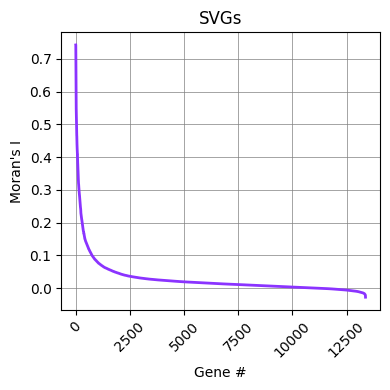

In [4]:
plot_svgs(adata)
plt.show()

We can modify the number of SVGs by setting a different threshold and replacing the `spatially_variable` column with the new selection.

In [5]:
moran_df = adata.var[adata.var["Moran's I"] > 0.08]
adata.var['spatially_variable'] = [True if x in moran_df.index else False for x in adata.var_names]

Next step is to run `chrysalis_pca` on the SVGs. Here we transform the count matrix with `scanpy`'s normalization and log transform functions, but alternative methods can also be used.

In [6]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

chrysalis_pca(adata, n_pcs=50)

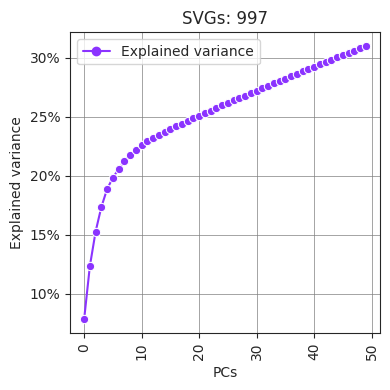

In [7]:
plot_explained_variance(adata)
plt.show()

`chrysalis_aa` infers tissue compartments. We can define the number of input PCs and the number of tissue compartments to be found. `chrysalis_plot` is used to visualize the results.

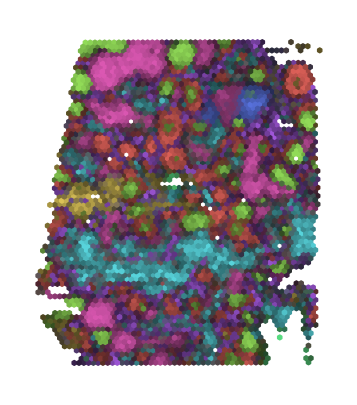

In [8]:
chrysalis_aa(adata, n_pcs=20, n_archetypes=8)
chrysalis_plot(adata, dim=8)
plt.show()

Gene expression signatures corresponding to the individual compartments.

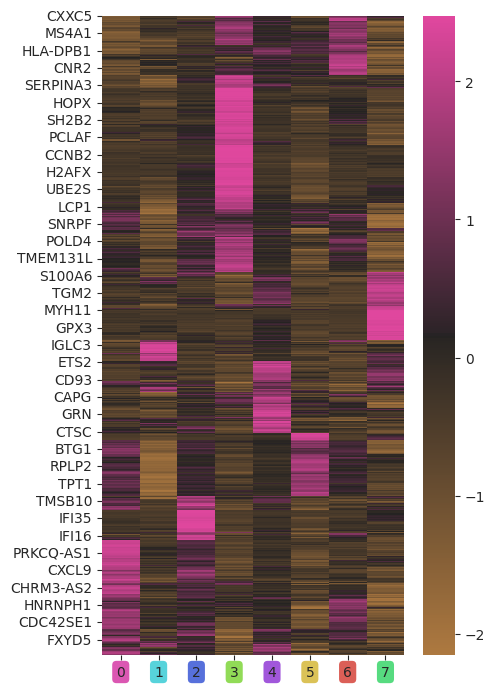

In [9]:
compartment_heatmap(adata)
plt.show()

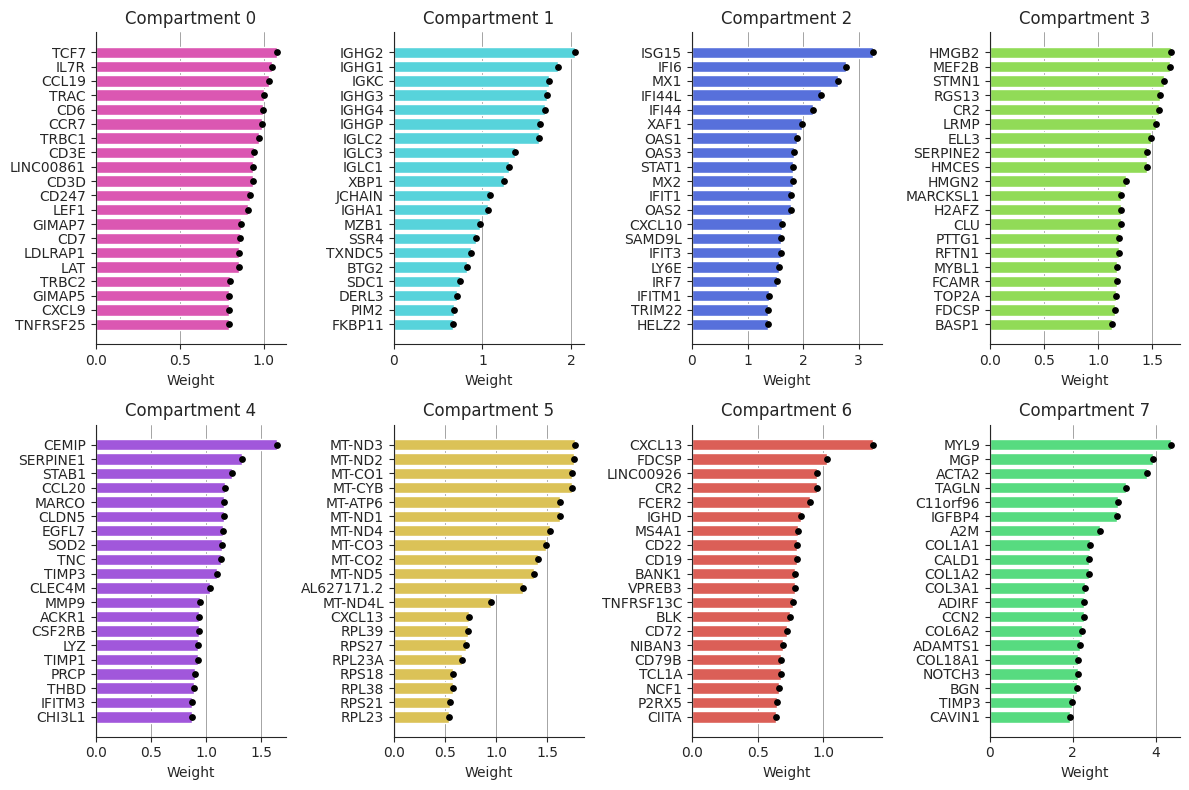

In [10]:
plot_weights(adata)
plt.show()

Visualize the compartments.

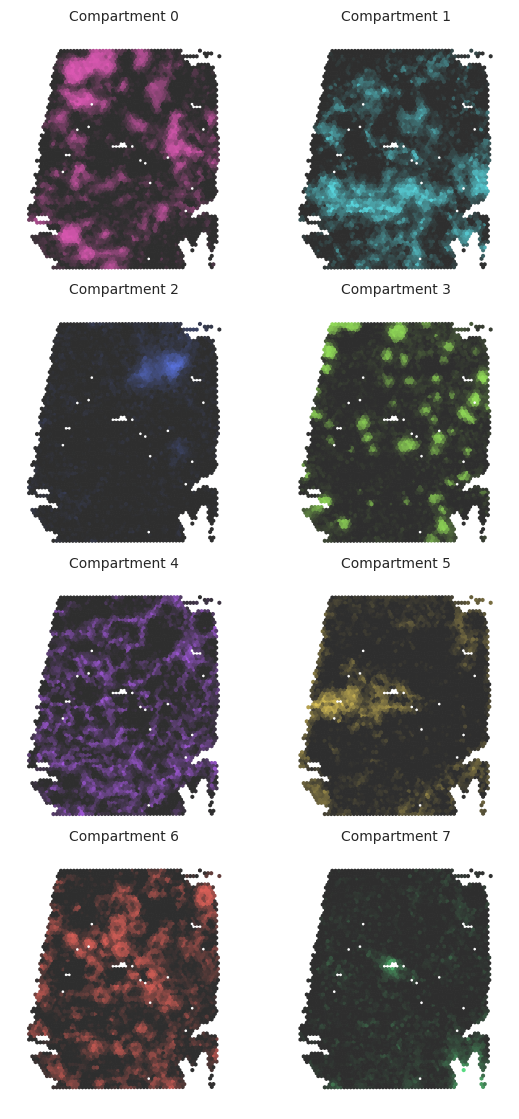

In [13]:
show_compartments(adata, ncols=2)
plt.show()

Finally, we can retrieve the gene expression values as a dataframe.

In [14]:
comp_df = get_compartment_df(adata)
print(comp_df.head())

          compartment_0  compartment_1  compartment_2  compartment_3  \
ISG15         -0.103527      -0.136616       3.252952      -0.239731   
RPL22          0.295535      -0.367732       0.071478      -0.011680   
TNFRSF25       0.791887      -0.060184       0.134404      -0.312538   
TNFRSF9       -0.159020      -0.198243       0.001034       0.137416   
ENO1           0.008693      -0.332119       0.269984       0.161277   

          compartment_4  compartment_5  compartment_6  compartment_7  
ISG15         -0.030029      -0.273345      -0.181935       0.643305  
RPL22         -0.041077       0.013251       0.147203      -0.671772  
TNFRSF25      -0.121334      -0.470862      -0.232911      -0.380425  
TNFRSF9        0.407721       0.041473      -0.006959      -0.478118  
ENO1           0.056409      -0.110826      -0.021805      -0.105444  
